## Software dependencies:
Besides the standard libraries associated with Python 3.10.12, our scripts have been tested with:

numpy 1.23.5

matplotlib 3.7.1


torch 2.0.1+cu11

## Hardware dependencies
We list below the hardware components used:

1 Intel(R) Xeon(R) CPU @ 2.30GHz

1 Nvidia Tesla V100

16 GB of RAM

The code takes less than 10 minutes to run on this hardware.

## Reproduciblity
In order to run each experiment, first run all the code in the Prelimanaries section, and then run the appropriate cell for the experiment.

We run each experiment with ten seeds from 1 to 10 for reproducibility purposes.

To optimize the GBT loss, we use LBFGS optimizer which is a quasi-Newton method: https://pytorch.org/docs/stable/generated/torch.optim.LBFGS.html

Since the GBT loss is strongly convex, the convergence speed of this algorithm is exremely fast and it converges to the optimum in two iterations with a very small error.

We ran each experiment around 20 times in total (e.g., for debugging) to obtain the desired result.  



# Prelimanaries

## Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import random
import copy
from tqdm.notebook import tqdm, trange
from collections import defaultdict
import torch

import time
import pandas as pd
from torch import log, sinh, cosh
from IPython.display import display, clear_output
import ipywidgets as widgets

# for GPU:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cuda.matmul.allow_tf32 = False
print(device)

cuda


## PLOT Functions


In [ ]:
def disp(arr, precision=2):
    print(np.round(np.array(arr), precision))

def seedall(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

def plot(data, legend=None, title="", log=False):
    def _plot_scaled(curve):
        if log:
            plt.semilogy(curve)
        else:
            plt.plot(curve)
    if not hasattr(data[0], '__iter__'):
        _plot_scaled(data)
    else:
        for curve in data:
            _plot_scaled(curve)
    if legend is not None:
        plt.legend(legend)
    plt.title(title)
    plt.show()
    plt.close()


def seeds_plot(list_list, x_values=None, legend=None, color=None, style=None, log=False, offset=0, confidence=True):
    nb_samples = len(list_list)
    if x_values is None:
        x_values = list(range(len(list_list[0])))[offset:]
    arr = np.array(list_list)
    arr = arr[:, offset:]
    vals = np.mean(arr, axis=0)
    if legend:
        if log:
            plt.semilogy(x_values, vals, label=legend, linestyle=style, color=color)
        else:
            plt.plot(x_values, vals, label=legend, linestyle=style, color=color)
    else:
        if log:
            plt.semilogy(x_values, vals, linestyle=style, color=color)
        else:
            plt.plot(x_values, vals, linestyle=style, color=color)
    if confidence:
        confs = 1.96 * np.std(arr, axis=0) / nb_samples**0.5
        plt.fill_between(list(x_values), vals - confs, vals + confs, alpha=0.1, color=color)
    return np.max(vals)


def seeds_plot_together(
    all_curves, legends=None, x_values=None, title="",
    log=False, offset=0, confidence=True, vlines=[], hlines=[], xlab=None, ylab=None,
    fsize=11, ranges=(None, None), figsize = (5, 5), save_name = None):
    """ all_curves: order 3 array/list of list of list """
    plt.figure(figsize = figsize)
    xmax, ymax = ranges
    colors = [ "blue", "red", "green", "orange" , "purple", "black"]
    styles = ["-", "--", "-.", ":", "-"]
    if legends is None:
        legends = [None] * len(all_curves)
    max_vals = []
    for curve, color, style, legend in zip(all_curves, colors, styles, legends):
        max_vals.append(seeds_plot(curve, x_values=x_values, color=color, style=style, legend=legend, log=log, offset=offset, confidence=confidence))
    for x in vlines:
        plt.axvline(x)
    for y in hlines:
        plt.axhline(y, color = "red")
    if legend is not None:
        plt.legend(prop={'size': fsize})
    plt.title(title)
    plt.xlabel(xlab, size=fsize)
    plt.ylabel(ylab, size=fsize)
    if save_name:
        plt.savefig(save_name, format="pdf", bbox_inches="tight")
    plt.show()
    plt.close()


def plot_corr(vals1, vals2, title="", burn_in=0, ps=1, ls=1):
    plt.scatter(vals1[burn_in:], vals2[burn_in:], s=ps)
    plt.plot([val[0][0] for val in vals1[burn_in:]], [val[0][0] for val in vals2[burn_in:]], lw=ls)
    plt.title(title)
    plt.show()

def compute_density(mat):
    high, width = mat.shape
    return np.count_nonzero(np.isnan(mat) == False) / high / width


## Synthetic Data

In [ ]:
def truncated_exp(theta_diff):
    # If the difference is zero, return a random number between -1 and 1
    if theta_diff == 0:
        return np.random.uniform(-1, 1)
    sample = 3
    param = np.absolute(theta_diff)
    while sample > 2:
        sample  = np.random.exponential(1/param)
    return  - (sample - 1) * theta_diff / param


def sample_r(density, theta_diff):
    return 1

def gen_data(nb_items, f_true, sigma, p_c):
    """
    Generate comparison matrices and true score values.

    Parameters:
    - nb_items: Number of items to be generated
    - f_true: Placeholder parameter, currently unused
    - sigma: Standard deviation for the normal distribution to generate theta_true
    - p_c: Probability used in binomial sampling to create the mask

    Returns:
    - comp_mat_c: Comparison matrix with some values masked
    - comp_mat: Original comparison matrix
    - theta_true: True values of theta
    """
    theta_true = np.random.normal(0, sigma, nb_items)
    comp_mat = np.zeros((nb_items, nb_items))
    # Fill the comparison matrix using the truncated exponential function
    for i in range(nb_items):
        for j in range(i + 1, nb_items):
            theta_ij = theta_true[i] - theta_true[j]
            r_ij = truncated_exp(theta_ij) # r_ij = sample_r(theta_ij, f_true)
            comp_mat[i][j] = r_ij
            comp_mat[j][i] = - r_ij

    # Create a mask for the provided comparisons
    mask = np.random.binomial(1, p=p_c, size=(nb_items, nb_items)) == 1
    for i in range(nb_items):
        mask[i][i] = False
        for j in range(i + 1, nb_items):
            mask[j][i] = mask[i][j]
    comp_mat_c = copy.copy(comp_mat)
    comp_mat_c[mask==False] = np.nan
    return comp_mat_c, comp_mat, theta_true # comp_mat_c is the partial graph

## GBT

In [ ]:
def binarise(comp_mat):
    comp_mat_bin = comp_mat > 0
    comp_mat_bin = comp_mat_bin.float()
    comp_mat_bin[comp_mat.isnan()] = torch.nan
    return comp_mat_bin * 2 - 1

def discretize(comp_mat, k):
   return np.round((comp_mat + 1) / 2 * (k - 1)) / (k - 1) * 2 - 1

In [ ]:
def phi_bin(theta):
    return log(cosh(theta))

def phi_kna(theta, k):
    val = theta / (k-1)
    return log(sinh(k * val) / k / sinh(val) )

def phi_poi(theta, lam):
    return lam * cosh(theta)

def phi_gau(theta, sigma):
    return 0.2 * sigma**2 * theta**2

def phi_uni(theta):
    return log(sinh(theta)/theta)

def phi_bet2(theta):
    num = theta * cosh(theta) - sinh(theta)
    return log(3 * num / (theta**3))

In [ ]:
# Defines the loss function for GBT
def loss_gbt(scores, comparisons, alpha, phi, **phi_kwargs):
    nb_items = len(scores)
    reg = alpha * torch.sum(scores**2) / 2
    i, j = torch.where(~torch.isnan(comparisons))
    valid_indices = j > i
    i = i[valid_indices]
    j = j[valid_indices]
    theta_ij = scores[i] - scores[j]
    fit = torch.sum(phi(theta_ij, **phi_kwargs) - comparisons[i, j] * theta_ij)
    return reg + fit


# Optimizing the loss function using the LBFGS optimizer
def compute_scores(comparisons, alpha, phi, nb_steps=10, lr=0.1, **phi_kwargs):
    def closure():
        lbfgs.zero_grad()
        objective = loss_gbt(scores, comparisons, alpha, phi, **phi_kwargs)
        objective.backward()
        return objective
    comparisons = torch.tensor(comparisons, device = device)
    nb_items = len(comparisons)
    scores = torch.normal(0, 1, (nb_items, ), requires_grad=True, dtype=float, device = device)
    lbfgs = torch.optim.LBFGS ((scores, ))
    hist_train = []
    for step in range(nb_steps):
        loss = loss_gbt(scores, comparisons, alpha, phi, **phi_kwargs)
        # print("iteration: ", str(step), ", loss: ", loss)
        lbfgs.step(closure)
        hist_train.append(loss.item())
    return scores.cpu().detach().numpy() , hist_train



# Error metric
def error_metric(theta_star, theta_true):
    return np.linalg.norm(theta_true - theta_star)**2/np.linalg.norm(theta_true)**2

# EXPERIMENTS

In order to run each experiment, first run all the above code (Prelimanaries), and then run the appropriate cell.

## Exp 1 (increasing k compared to uniform)

Output()

Done!


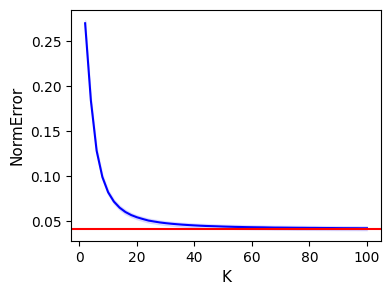

In [ ]:
#paramters:
seeds = [1,2,3,4,5,6,7,8,9,10]
nb_items = 500
f_true = None  # uniform
sigma = 1
p_c = 0.2
alpha = 1
f_guessed = f_true
nb_steps = 3

output_widget = widgets.Output()
display(output_widget)

err_kna_seed = []
err_uni_seed = []


#estimtation of the scores for K \in [2,100]:
for seed in seeds:
    seedall(seed)
    comp_mat_c, comp_mat_full, theta_true = gen_data(nb_items, f_true, sigma, p_c)
    k_params = list(range(2, 101, 2))
    scores_kna, hists_kna = {}, {}
    for k in k_params:

        with output_widget:
            clear_output(wait=True) # Clear previous output
            print(f"seed:{seed}, k: {k}")

        comp_mat_disc = discretize(comp_mat_c, k)
        scores, hist = compute_scores(comp_mat_disc, alpha, phi_kna, nb_steps=nb_steps, k=k)
        scores_kna[k] = scores
        hists_kna[k] = hist
    scores_uni, hist_uni = compute_scores(comp_mat_c, alpha, phi_uni, nb_steps=nb_steps)
    errs = []
    for k, scores in scores_kna.items():
        errs.append(error_metric(scores, theta_true))
    err_kna_seed.append(errs)

    err_uni = error_metric(scores_uni, theta_true)
    err_uni_seed.append(err_uni)
print("Done!")
seeds_plot_together([err_kna_seed], x_values=k_params, xlab="K", hlines=[sum(err_uni_seed)/ len(err_uni_seed)], ylab="NormError", figsize = (4,3))
# to save the plot run the following instead:
# seeds_plot_together([err_kna_seed], x_values=k_params, xlab="K", hlines=[sum(err_uni_seed)/ len(err_uni_seed)], ylab="NormError", figsize = (4,3), save_name = f"{images_dir}/K.pdf")

## Exp 2 (increasing p_c)

Output()

Done!


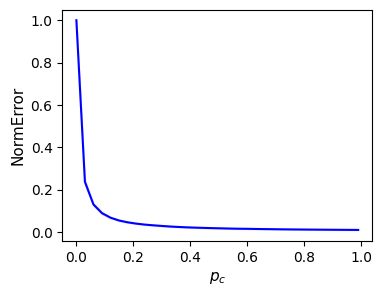

In [ ]:
#paramters:

seeds = [1,2,3,4,5,6,7,8,9,10]
nb_items = 500
f_true = None # uniform
sigma = 1
alpha = 1
f_guessed = f_true
nb_steps = 3

output_widget = widgets.Output()
display(output_widget)

#estimtation of the scores for pc \in [0,1]:


p_params =  list(np.arange(0.0, 1.001, 0.03))

err_seeds = []
for seed in seeds:
    scores_p, hists_p = {}, {}
    for p_c in p_params:

        with output_widget:
            clear_output(wait=True) # Clear previous output
            print(f"seed:{seed}, pc: {p_c}")


        seedall(seed)
        comp_mat_c, comp_mat_full, theta_true = gen_data(nb_items, f_true, sigma, p_c)
        scores, hist = compute_scores(comp_mat_c, alpha, phi_uni, nb_steps=nb_steps)
        scores_p[p_c] = scores
        hists_p[p_c] = hist

    errs = []
    for p_c, scores in scores_p.items():
        errs.append(error_metric(scores, theta_true))
    err_seeds.append(errs)
print("Done!")
seeds_plot_together([err_seeds], x_values=p_params, xlab="$p_c$", ylab="NormError", figsize = (4,3))
# to save the plot run the following instead:
# seeds_plot_together([err_seeds], x_values=p_params, xlab="$p_c$", ylab="NormError", figsize = (4,3), save_name = f"{images_dir}/pc.pdf")

## Exp 3 (comparison alpha-sigma)

Output()

Done!


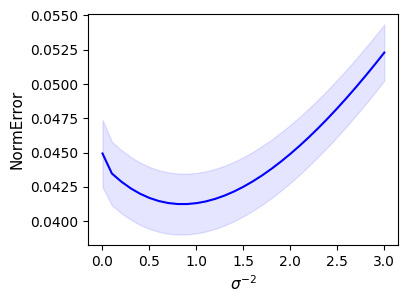

In [ ]:
#parameters:

seeds = [1,2,3,4,5,6,7,8,9,10]
nb_items = 500
f_true = None # uniform
sigma = 1
p_c = 0.2
f_guessed = f_true
nb_steps = 3


output_widget = widgets.Output()
display(output_widget)

#estimtation of the scores for alpha \in [0,3]:

err_seed = []
for seed in seeds:
    seedall(seed)
    comp_mat_c, comp_mat_full, theta_true = gen_data(nb_items, f_true, sigma, p_c)
    alpha_params = list(np.arange(0.0, 3.1, 0.1))
    scores_alpha, hists_alpha = {}, {}
    for alpha in alpha_params:

        with output_widget:
            clear_output(wait=True) # Clear previous output
            print(f"seed:{seed}, alpha: {alpha}")

        scores, hist = compute_scores(comp_mat_c, alpha, phi_uni, nb_steps=nb_steps)
        scores_alpha[alpha] = scores
        hists_alpha[alpha] = hist

    errs = []
    for alpha, scores in scores_alpha.items():
        errs.append(error_metric(scores, theta_true))
    err_seed.append(errs)

print("Done!")
seeds_plot_together([err_seed], x_values=alpha_params, xlab='${\sigma^{-2}}$', ylab="NormError", figsize = (4,3))
# to save the plot run the following instead:
# seeds_plot_together([err_seed], x_values=alpha_params, xlab='${\sigma^{-2}}$', ylab="NormError", figsize = (4,3), save_name = f"{images_dir}/alpha.pdf")